## LC Model Search Framework

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [16]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

In [3]:
exp_name = 'fullval_keras_tests_corrected'
model_name = 'cnn_single'
filepath = 'model_search/' +  model_name + '--' + exp_name + '.hdf5' #your filepath here

Assign your specific GPU so we don't overlap

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [6]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [7]:
tiles = {}
landsat_datasets = {}
# tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
# tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
# tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

tiles['028012'] = ['20110308']
tiles['029011'] = ['20110308']
tiles['028011'] = ['20110308']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [8]:
train_gdf = gpd.read_file('../shapefiles/train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name'], row['label']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((2623, 1065), '029011', 0))

In [9]:
# train_gdf = gpd.read_file('../shapefiles/train_buffered_points140520_valsubset.shp')
# train_px = []

# per_class_count = [0] * 6
# total_per_class_count = [0] * 6

# for index, row in train_gdf.iterrows():
#     if not row['reject']:
#         total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
#         if per_class_count[int(row['manual_val'])] < 110:
#             per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
#             train_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
# random.shuffle(train_px)

# len(train_px), train_px[0]

In [10]:
val_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
val_px = []


per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 120:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(720, ((337.0, 3749.0), '028011', 1))

In [11]:
total_per_class_count, per_class_count

([153, 152, 152, 137, 132, 139], [120, 120, 120, 120, 120, 120])

### Create the RNN

In [12]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [20]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel rnn model
    #block = strangeBlock_v4(input_tensor, 5, 12)
    #block_2 = strangeBlock_v4(block, 3, 20)
    #final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer2)
    flatten = Flatten()(maxpool)
    #concat = concatenate([final_block, flatten])
    
    # this makes it a RCNN + LSTM
    #denselayer = Dense(64, activation="elu")(concat)
    # this makes it just an RCNN
    denselayer = Dense(64, activation="elu")(flatten)
    # this makes it just an LSTM
    #denselayer = Dense(64, activation="elu")(final_block)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

Start the experiments here:

In [12]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/66e4aea91f9643e9bc94a4b6255dd03c



In [13]:
experiment.add_tag(exp_name + '_' + model_name)

In [14]:
tile_size = 9
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 60
batch_size = 25
steps_division_factor = 10

#### This is the simple MLP Model

In [14]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=((tile_size*tile_size*len(tiles['028012'])*7),)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                90752     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 92,006
Trainable params: 92,006
Non-trainable param

#### This is the simple CNN Model

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(tile_size,tile_size,7*len(tiles['028012']))))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 7, 32)          2048      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________

#### This makes the RCNN model

In [24]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
model.summary()
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tile_input (InputLayer)      (None, 1, 9, 9, 7)        0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 1, 7, 7, 64)       163840    
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 5, 5, 64)          295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
_________________________________________________________________
landcover (Dense)            (None, 6)                 390 

train the model in a loop to see impact of training sample count

In [44]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# 2000 tiles
#tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
#tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
#tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [45]:
tiles = {}
landsat_datasets = {}
# tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
# tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
# tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# 2000 tiles
tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_gen2000 = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [46]:
val_gdf2000 = gpd.read_file('../shapefiles/test1999_buffered_points140520_val_subset.shp')

val_px2000 = []
val2000_labels = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf2000.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 100:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px2000.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
            val2000_labels.append(int(row['manual_val']))

10
0.7757142867360797
0.6866666666666666
20
0.8914285664047513
0.815
40
0.8957142787320274
0.7083333333333334
80
0.947142847946712
0.7616666666666667
100
0.9485714201416288
0.8583333333333333
200
0.95714285331113
0.835
300
0.9557142789874759
0.8583333333333333
400
0.9628571378333228
0.8666666666666667
500
0.9685714223555156
0.8683333333333333
600
0.9614285635096687
0.8833333333333333
700
0.9685714223555156
0.865
800
0.9757142790726253
0.84
900
0.9728571389402662
0.8916666666666667
1000
0.9728571346827916
0.845
1100
0.975714276943888
0.865
1200
0.9728571368115289
0.8716666666666667
1300
0.9742857090064457
0.8
1400
0.9728571431977409
0.86
1500
0.9671428544180733
0.8583333333333333


(0.5, 1)

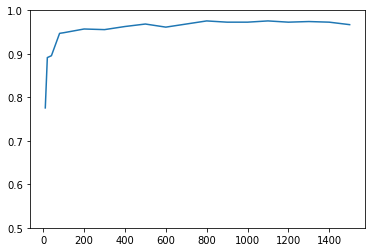

In [48]:
accuracies = []
val_accuracies = []
train_counts = [10, 20, 40, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
epochs = 50
steps_division_factor = 1

for train_count in train_counts:
    print(train_count)

    model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
    model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

    history = model.fit_generator(generator=tile_gen.tile_generator(train_px[:train_count*6], batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px[:train_count*6]) // batch_size // steps_division_factor, epochs=epochs, verbose=False,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size) 

    accuracies.append(max(history.history['val_acc']))
    print(max(history.history['val_acc']))
    
    predictions = model.predict_generator(generator = tile_gen2000.tile_generator(val_px2000, batch_size=40, flatten=True, canopy=True), steps=len(val_px2000) //40, verbose=False)
    pred_index = np.argmax(predictions, axis=-1)
    val_acc = np.sum(pred_index == np.array(val2000_labels))/len(val2000_labels)
    print(val_acc)
    val_accuracies.append(val_acc)

#keras.backend.clear_session()

plt.plot(train_counts, accuracies)
plt.ylim(.5,1)

(0.5, 1)

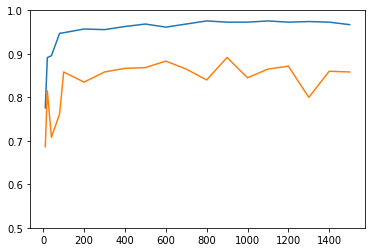

In [49]:
plt.plot(train_counts, accuracies)
plt.plot(train_counts, val_accuracies)
plt.ylim(.5,1)

5
0.9685714287417275
0.8866666666666667
7
0.9699999945504325
0.895
9
0.9685714244842529
0.9033333333333333
11
0.9728571368115289
0.9066666666666666
13
0.974285711135183
0.8533333333333334


(0.5, 1)

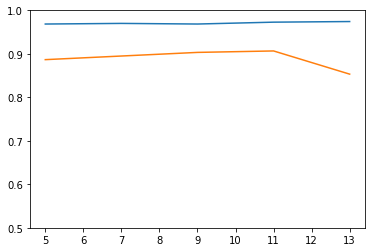

In [42]:
accuracies = []
val_accuracies = []
tile_size_list = [5,7,9,11,13]
epochs = 50
steps_division_factor = 10

for tile_size in tile_size_list:
    print(tile_size)
    tiles = {}
    landsat_datasets = {}
    tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
    tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
    tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

    for tile_number, dates in tiles.items():
        tile_datasets = []
        l8_image_paths = []
        for date in dates:
            l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
        for fp in l8_image_paths:
            tile_datasets.append(rasterio.open(fp))
        landsat_datasets[tile_number] = tile_datasets

    tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
    
    tiles = {}
    landsat_datasets = {}

    # 2000 tiles
    tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
    tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
    tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

    for tile_number, dates in tiles.items():
        tile_datasets = []
        l8_image_paths = []
        for date in dates:
            l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
        for fp in l8_image_paths:
            tile_datasets.append(rasterio.open(fp))
        landsat_datasets[tile_number] = tile_datasets

    tile_gen2000 = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

    model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
    model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

    history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=False,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size) 

    accuracies.append(max(history.history['val_acc']))
    print(max(history.history['val_acc']))
    
    predictions = model.predict_generator(generator = tile_gen2000.tile_generator(val_px2000, batch_size=40, flatten=True, canopy=True), steps=len(val_px2000) //40, verbose=False)
    pred_index = np.argmax(predictions, axis=-1)
    val_acc = np.sum(pred_index == np.array(val2000_labels))/len(val2000_labels)
    print(val_acc)
    val_accuracies.append(val_acc)

#keras.backend.clear_session()

plt.plot(tile_size_list, accuracies)
plt.plot(tile_size_list, val_accuracies)
plt.ylim(.5,1)

In [ ]:
tils size vs acc
5
0.9685714287417275
0.8866666666666667
7
0.9699999945504325
0.895
9
0.9685714244842529
0.9033333333333333
11
0.9728571368115289
0.9066666666666666
13
0.974285711135183
0.8533333333333334

#### Train the Model

In [17]:
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [18]:
steps_division_factor = 2

In [19]:
# load model if fine-tuning
#model = keras.models.load_model('model_search/rcnn--fullval_keras_tests.hdf5')

train_time_start = datetime.datetime.now()

history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=False), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=False),
                validation_steps=len(val_px) // batch_size,
                callbacks=callbacks_list) 

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start

COMET WARNING: Set model graph by 'keras' ignored; already called. Future attempts are silently ignored.


Epoch 1/60
 1/36 [..............................] - ETA: 36s - loss: 2.5278 - acc: 0.2000

COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE


KeyError: 0

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])


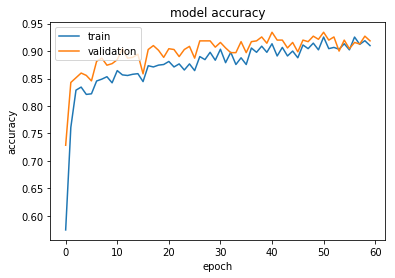

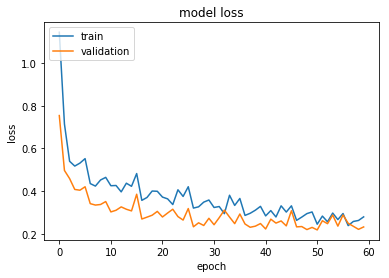

In [28]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_acc")
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_loss")
plt.show()

In [29]:
filepath = filepath.replace('_corrected','')
filepath

'model_search/rcnn_single--fullval_keras_tests.hdf5'

In [32]:
model = keras.models.load_model(filepath)

# Evaluate model

#### change evaluation dataset

In [71]:
dataset_name = '2010val' # '2010val' '2010test' '2000test' '2000test_corrected'

In [72]:
tiles = {}
landsat_datasets = {}
#tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
#tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
#tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

tiles['028012'] = ['20110308']
tiles['029011'] = ['20110308']
tiles['028011'] = ['20110308']

# 2000 tiles
# tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
# tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
# tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

# tiles['028012'] = ['20000410']
# tiles['029011'] = ['20000410']
# tiles['028011'] = ['20000410']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [73]:
val_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
#val_gdf = gpd.read_file('../shapefiles/test_buffered_points140520_val.shp')
#val_gdf = gpd.read_file('../shapefiles/test1999_buffered_points140520_val_subset.shp')

val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 120:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [74]:
total_per_class_count, per_class_count

([153, 152, 152, 137, 132, 139], [120, 120, 120, 120, 120, 120])

In [75]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [76]:
inference_time_start = datetime.datetime.now()

predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=40, flatten=True, canopy=True), steps=len(val_px) //40, verbose=1)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start

eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

18/18 [==============================] - 1s 40ms/step


In [77]:
predictions.shape

(720, 6)

In [78]:
lc_predictions = predictions

In [79]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #print(label_b.shape)
        #label_b = np.argmax(label_b, axis=-1)
        #print(label_b)
        label_b = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_b
        count += 1
label_index = lc_lab
pred_index = np.argmax(lc_predictions, axis=-1)

Accuracy is 0.9486111111111111
per_class_acc 1.0
per_class_acc 0.9083333333333333
per_class_acc 0.95
per_class_acc 0.9666666666666667
per_class_acc 0.9333333333333333
per_class_acc 0.9333333333333333


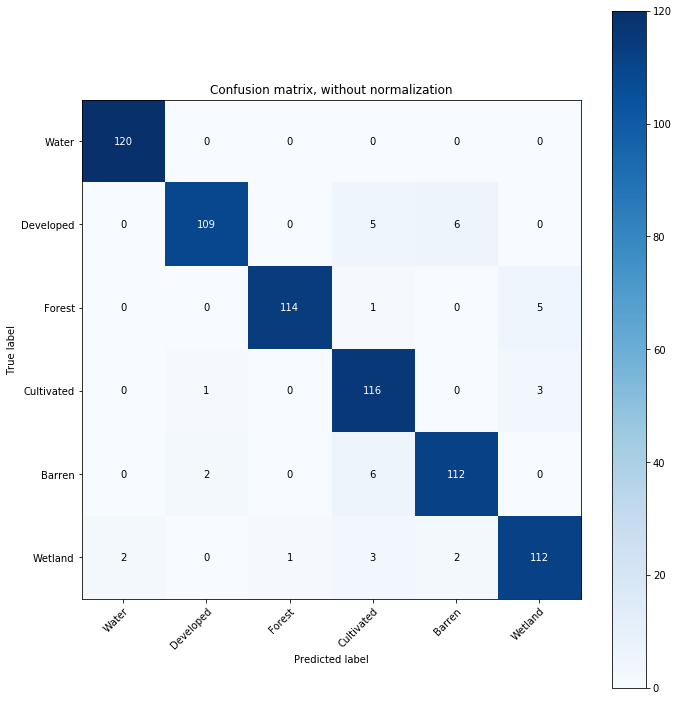

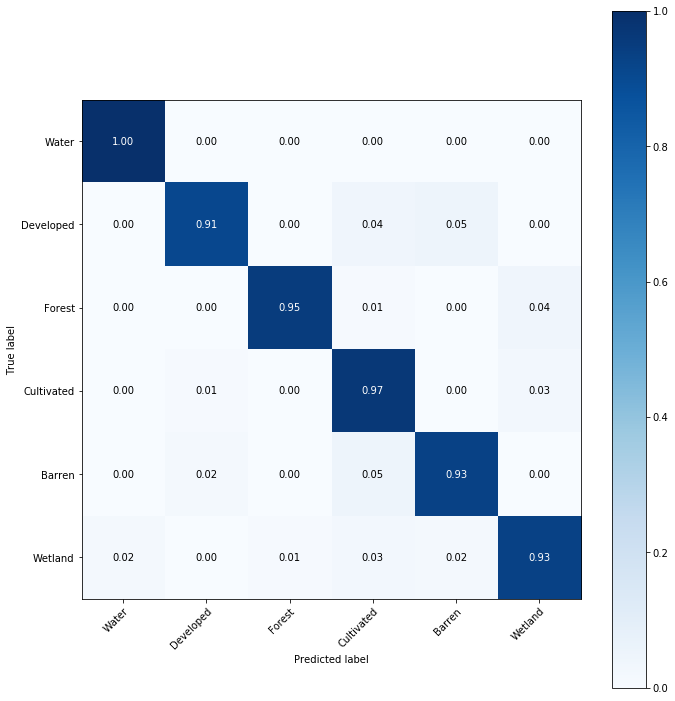

In [80]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix" + dataset_name)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix" + dataset_name)
count = 0
per_class_acc = [0] * 6
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        per_class_acc[int(label_index[i])] = per_class_acc[int(label_index[i])] + 1
        count+=1

val_accuracy=count/len(label_index)
class_acc_dict = {}
print("Accuracy is",val_accuracy)
# this is producer's accuracy
for idx, class_correct in enumerate(per_class_acc):
    class_acc_dict[class_dict[idx]] = round(class_correct/(int(len(label_index)/class_count)),4)
    print('per_class_acc', class_correct/(per_class_count[idx]))

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [81]:
import pandas as pd
import seaborn as sns

experiment_df = pd.DataFrame(columns=['exp_name','model_name', 'evaluation_dataset', 'time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [163]:
training_time=0

In [82]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, dataset_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [83]:
experiment_df.tail(5)

,exp_name,model_name,evaluation_dataset,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,fullval_keras_tests_corrected,rcnn_single,2010val,1,1500.0,0.948611,60,9,00:01:22.874808,00:00:00.723998,...,0.95,0.967,0.933,0.933,0.984,0.973,0.991,0.885,0.933,0.933


In [84]:
experiment_df.to_csv('model_search/' + model_name + '-' + exp_name + dataset_name + '.csv')

In [85]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


#### Go back and run all of the different datasets before ending the experiment

In [86]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "steps_division_factor":steps_division_factor,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [87]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/0de06c38291849ee87ac449a9574b115
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [60]                  : (0.5744444452640083, 0.9255555537011888)
COMET INFO:     batch_acc [240]           : (0.11999999731779099, 1.0)
COMET INFO:     batch_loss [240]          : (0.045803364366292953, 1.8013156652450562)
COMET INFO:     epoch_duration [60]       : (1.1967078209854662, 4.404056549072266)
COMET INFO:     loss [60]                 : (0.2378175975754857, 1.1459342887004216)
COMET INFO:     val_acc [60]              : (0.728571429848671, 0.9342857130936214)
COMET INFO:     val_loss [60]             : (0.2176028358350907, 0.7546446004084179)
COMET INFO:     validate_batch_acc [180]  : (0.6000000238418579, 1.0)
COMET INFO:   

In [88]:
filepath

'model_search/rcnn_single--fullval_keras_tests_corrected.hdf5'